ニューラルネットワークで学習してみる  
ここではオックスフォードのCNNを参考にして学習

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


Load dataset

In [2]:
fold = "../train_raw_npy/"
xyz = np.load(f"{fold}acc_xyz.npy")
label = np.load(f"{fold}sampled_label.npy")
print(xyz.shape)
print(label.shape)

(196072, 3, 500)
(196072,)


train / test spilit

In [3]:
pin = 170000
train_xyz = xyz[0:pin,:,:]
test_xyz = xyz[pin:190000, :, :]
train_label = label[0:pin]
test_label = label[pin:190000]
print(train_xyz.shape)
print(test_xyz.shape)

(170000, 3, 500)
(20000, 3, 500)


In [24]:
# 全体をシャッフル
from sklearn.model_selection import train_test_split
train_xyz, test_xyz, train_label, test_label = train_test_split(xyz, label, test_size=0.2, random_state=42)


In [25]:
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())

5.0    25312
7.0    24946
6.0    22699
2.0    19656
1.0    19551
8.0    19073
4.0    18787
3.0     6833
Name: count, dtype: int64
5.0    6421
7.0    6307
6.0    5627
1.0    4905
2.0    4888
8.0    4761
4.0    4686
3.0    1620
Name: count, dtype: int64


In [5]:
# trainをランダムに40000個サンプリングする。
sample_size = train_xyz.shape[0]
indices = np.random.choice(train_xyz.shape[0], sample_size, replace=False)
train_xyz_random = train_xyz[indices]
train_label_random = train_label[indices]


In [26]:
# train_randomの生成
train_xyz_random = train_xyz
train_label_random = train_label

In [27]:
print(train_xyz_random.shape)

(156857, 3, 500)


# アーキテクチャデザイン  
オックスフォードでの例にあるようにCNNを使う

In [7]:
class ConvBNReLU(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,

            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            dropout=0.0 # ドロップアウト率を新規追加
    ):
        super(ConvBNReLU, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(True)
        )
        if dropout > 0:
            self.main.append(nn.Dropout(dropout))
    
    def forward(self,x):
        return self.main(x)


In [8]:
class CNN(nn.Module):
    def __init__(self, output_size=8, in_channels=3, num_filters_init=8, dropout=0.0):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            ConvBNReLU(in_channels, num_filters_init, 8,2,3), # 500 -> 250 
            ConvBNReLU(num_filters_init, num_filters_init*2, 6,2,2,dropout=dropout ), # 250 -> 125 (248)
            ConvBNReLU(num_filters_init*2, num_filters_init*4,7,2,2), # 125 -> 62
            ConvBNReLU(num_filters_init*4, num_filters_init*8,6,2,1, dropout=dropout ), # 62 -> 30
            ConvBNReLU(num_filters_init*8, num_filters_init*16, 4, 4, 1), # 30 -> 8
            ConvBNReLU(num_filters_init*16, num_filters_init*32, 8,1,0, dropout=dropout), # 8 -> 1
            nn.Conv1d(num_filters_init*32, output_size, 1,1,0)
        )
    
    def forward(self, x):
        return self.cnn(x).view(x.shape[0], -1) # ここってもしかして(N, 1500)にしていたりするのかな？

懸念事項１  
cnnのカーネルとかのサイズの計算が合っていない可能性がある

懸念事項３  
クラスラベルの変更0~7に  
これは関数側で対応することにする。  
学習時や推論時は考えなくていいようにする。(SHL用の関数を作成するということ)  
0~7クラス分類で学習し、1~8クラス分類として表示する。

In [9]:
def create_dataloader(X, y=None, batch_size=1, shuffle=False):
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    
    #データセットをバッチサイズごとに分割
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = X[idxs_batch].astype('f4')

        X_batch = torch.from_numpy(X_batch)
        if y is None:
            yield X_batch
        else:
            y_batch = y[idxs_batch]
            y_batch = torch.from_numpy(y_batch-1)
            yield X_batch, y_batch

In [10]:
def forward_by_batches(cnn, X):
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=1024, shuffle=False):
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()

    Y = torch.cat(Y) # Yをテンソルに変換
    return Y

In [11]:
def evaluate_model(cnn, X, Y):
    Y_pred = forward_by_batches(cnn, X)
    loss = F.cross_entropy(Y_pred, torch.from_numpy(Y-1.0).type(torch.int64).to(device)).item() # クロスエントロピー損失の計算 仕方なく0~7クラス分類とする

    Y_pred = F.softmax(Y_pred, dim=1) 
    Y_pred = torch.argmax(Y_pred, dim=1)  # 最も高い確率のY_predのラベルを予測ラベルとしてY_predに入れられる。
    Y_pred = Y_pred + 1  # 予測ラベルに1を加えて1~8の範囲に変換する
    Y_pred = Y_pred.cpu().numpy()  # テンソルでGPUにのっているものをcpuに移動して、それをさらにnumpy配列に変換している。
    kappa = metrics.cohen_kappa_score(Y, Y_pred) # 1~8クラス分類

    return {'loss':loss, 'kappa':kappa, 'Y_pred':Y_pred}

懸念事項２  
クラス分類は1~8である。したがって0~7のクラス分類を1~8に移動させてあげる必要がある。

In [44]:
num_filters_init = 10
in_channels = 3  
output_size = len(np.unique(train_label_random))  #　これは分類するラベルの数。最終層の特徴量の数
num_epoch = 5  # num of epochs (full loops though the training set)
lr = 3e-4  # learning rate 
batch_size = 64  # size of the mini-batch　バッチサイズを32にしている。

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init,
    dropout=0.3
).to(device)
print(cnn) # ここではcnnのネットワーク構造の定義をして、そのネットワークの構造をprintしている。

loss_fn = nn.CrossEntropyLoss() # クロスエントロピー損失を使用してモデルの出力と実際のラベルとの差を計算するためのインスタンス定義
optimizer = optim.Adam(cnn.parameters(), lr=lr) # オプティマイザーを使用し、設定された学習率lrでモデルのパラメータを最適化する。Adamはよく使われるやつでパフォーマンスが高いらしい　
# optim.Adam()ではcnnのパラメータへの直接参照をすることができるnum_filters

CNN(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(3, 10, kernel_size=(8,), stride=(2,), padding=(3,))
        (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(10, 20, kernel_size=(6,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(20, 40, kernel_size=(7,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvBNReLU(
      (main): Sequential(
        (0): Conv1d(40, 80, kernel_size=(6,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(80, eps=1e

In [47]:
kappa_history_test = []
loss_history_test = []
loss_history_train = []
losses = []
num_epoch = 20
for i in tqdm(range(num_epoch)): # 同じデータセットでnum_epoch回cnnを学習させている。
    dataloader = create_dataloader(train_xyz_random, train_label_random, batch_size, shuffle=True)
    for x, target in dataloader:
        x, target = x.to(device), target.type(torch.int64).to(device)
        cnn.zero_grad()
        output = cnn(x) # バッチxをネットワークに通し、予測値outputを取得
        loss = loss_fn(output, target) # 予測値と実際のラベルtargetとの間の損失を計算する。ネットワークの出力outputと正解targetとの間の差異を計算しその結果としてスカラー値lossを生成する。
        loss.backward() # 計算されたlossに従ってネットワークのすべてのパラメータに対する勾配が計算される。
        optimizer.step() # オプティマイザが保存している勾配情報を使用してモデルのパラメータを更新　直接cnnに紐づいているのでcnnのパラメータを直接更新している

        # Logging -- track train loss
        losses.append(loss.item()) # ログを残している。lossというのはパラメータのgradientでパラメータを更新する方向や大きさを決めている。

    # --------------------------------------------------------
    #       Evaluate performance at the end of each epoch
    # --------------------------------------------------------

    # Logging -- average train loss in this epoch
    loss_history_train.append(utils.ewm(losses))

    # Logging -- evalutate performance on test set
    results = evaluate_model(cnn, test_xyz, test_label)
    loss_history_test.append(results['loss'])
    kappa_history_test.append(results['kappa'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
results

{'loss': 0.6797428131103516,
 'kappa': 0.6879426634541737,
 'Y_pred': array([6, 4, 4, ..., 6, 1, 6], dtype=int64)}


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.50      0.79      0.61      4905
         2.0       0.97      0.93      0.95      4888
         3.0       1.00      0.99      0.99      1620
         4.0       0.98      0.95      0.96      4686
         5.0       0.89      0.81      0.85      6421
         6.0       0.75      0.71      0.73      5627
         7.0       0.55      0.56      0.56      6307
         8.0       0.52      0.33      0.40      4761

    accuracy                           0.73     39215
   macro avg       0.77      0.76      0.76     39215
weighted avg       0.75      0.73      0.73     39215



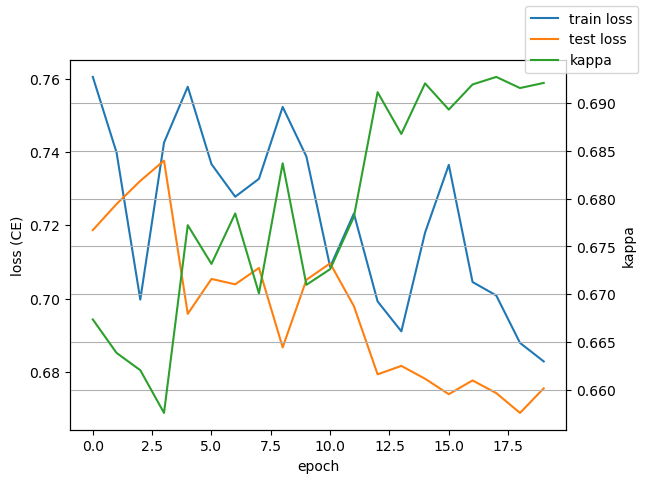

In [48]:
# Loss history
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))


Classifier performance
Out of sample:
               precision    recall  f1-score   support

         1.0       0.53      0.75      0.62      4905
         2.0       0.98      0.92      0.95      4888
         3.0       0.99      0.99      0.99      1620
         4.0       0.98      0.95      0.96      4686
         5.0       0.92      0.77      0.84      6421
         6.0       0.70      0.72      0.71      5627
         7.0       0.51      0.63      0.56      6307
         8.0       0.51      0.27      0.35      4761

    accuracy                           0.73     39215
   macro avg       0.76      0.75      0.75     39215
weighted avg       0.74      0.73      0.72     39215



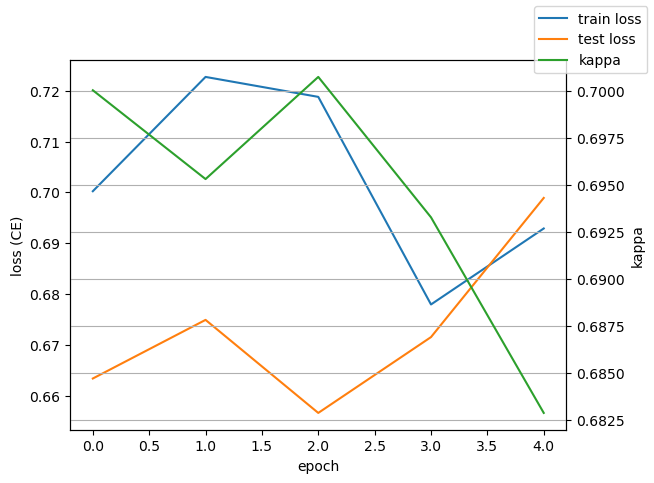

In [43]:
# Loss history 追加のグラフ表示のため
plt.close('all')
fig, ax = plt.subplots()
ax.plot(loss_history_train, color='C0', label='train loss')
ax.plot(loss_history_test, color='C1', label='test loss')
ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')
ax = ax.twinx()
ax.plot(kappa_history_test, color='C2', label='kappa')
ax.set_ylabel('kappa')
ax.grid(True)
fig.legend()

# Report
#Y_test_pred_lab = le.inverse_transform(results['Y_pred'])  # back to text labels
#Y_test_lab = le.inverse_transform(test_label)  # back to text labels
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(test_label, results['Y_pred']))

C:\Users\kaiha\AppData\Local\Temp\ipykernel_3568\3836056030.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


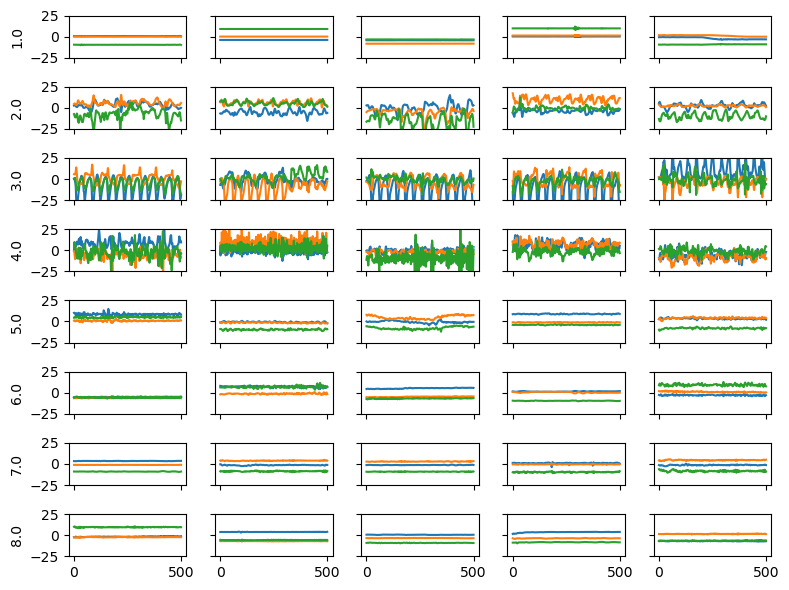

In [66]:
NPLOTS = 5
temp_xyz = np.transpose(train_xyz_random, (0,2,1))
unqY = np.unique(train_label_random)
#subplotsについて　５つのアノテーションとそれらに対して５つのグラフをそれぞれ出力するようにしている。
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(8,6)) # sharex, shareyはすべてのサブプロットでx軸y軸を共有することを意味する。
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(train_label_random==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(temp_xyz[idxs], row):
        ax.plot(x)
        # ここにylimの設定を細かく設定して、それぞれの波形についてもう少し詳しく見たい。2,3,4は予想どうり推測しやすそうな波で安心
        ax.set_ylim(-25,25)
fig.tight_layout()
fig.show()

次もまたNNを作る。  
cnnでもいいけど、他の種類のやつとかも試してみたさがある。  
例えばRNNの場合、どういうデータを時系列として処理できるのか。各データポイントの500次元に対して、もしくは訓練データ全体を時系列にするか。  
訓練データ全体を時系列とするなら、予測結果のスムージングになるのかな。なら500次元を時系列とするようなやつとかならどうだろうか。